In [1]:
import xarray as xr
import numpy as np
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

path_aibedo = '/Users/shazarika/ProjectSpace/currentProjects/AiBEDO/codebase/11_07_22/aibedo/'
sys.path.append(path_aibedo)
os.chdir(path_aibedo)

import xarray as xr
import numpy as np
from typing import *
import wandb
import torch
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import proplot as pplt
from aibedo.models import BaseModel
from aibedo.utilities.wandb_api import reload_checkpoint_from_wandb, get_run_ids_for_hyperparams
import scipy.stats
import matplotlib.patches as patches
import hydra
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf, DictConfig
from aibedo.utilities.config_utils import get_config_from_hydra_compose_overrides
from aibedo.utilities.utils import rsetattr, get_logger, get_local_ckpt_path, rhasattr, rgetattr


In [3]:
from aibedo.interface import reload_model_from_config_and_ckpt
def load_model(config_path,config_name,ckpt_path,ckpt_name):
    overrides = [f'datamodule.data_dir={DATA_DIR}', f"++model.use_auxiliary_vars=False"]
    
    print(overrides)
    print(config_path,config_name,ckpt_path,ckpt_name)

    ### Load Hydra config file
    GlobalHydra.instance().clear() 
    hydra.initialize(config_path=config_path, version_base=None)
    config = hydra.compose(config_name=config_name, overrides=overrides)
    config['ckpt_dir'] = ckpt_path
    config['callbacks']['model_checkpoint']['dirpath'] = config['ckpt_dir']
    

    ## Modify config dict
    if config.model.get('input_transform'):
        OmegaConf.update(config, f'model.input_transform._target_',
                         str(rgetattr(config, f'model.input_transform._target_')).replace('aibedo_salva', 'aibedo'))
    for k in ['model', 'datamodule', 'model.mixer', 'model.input_transform']:
        if config.get(k):
            OmegaConf.update(config, f'{k}._target_',
                             str(rgetattr(config, f'{k}._target_')).replace('aibedo_salva', 'aibedo'))
    
    ## Load model
    loadmodel = reload_model_from_config_and_ckpt(config, ckpt_path+ckpt_name, load_datamodule=True)

    return loadmodel[0], config

def concat_variables_into_channel_dim(data: xr.Dataset, variables: List[str]) -> np.ndarray:
    """Concatenate xarray variables into numpy channel dimension (last)."""
    assert len(data[variables[0]].shape) == 2, "Each input data variable must have two dimensions"
    data_ml = np.concatenate(
        [np.expand_dims(data[var].values, axis=-1) for var in variables],
        axis=-1  # last axis
    )
    return data_ml.astype(np.float32)

def get_month_of_output_data(output_xarray: xr.Dataset) -> np.ndarray:
    """ Get month of the snapshot (0-11)  """
    n_gridcells = len(output_xarray['ncells'])
    # .item() is required here as only one timestep is used, the subtraction with -1 because we want 0-indexed months
    month_of_snapshot = np.array(output_xarray['time.month'], dtype=np.float32) - 1
    # now repeat the month for each grid cell/pixel
    dataset_month = np.repeat(month_of_snapshot, n_gridcells)
    return dataset_month.reshape([month_of_snapshot.shape[0], n_gridcells, 1])  # Add a dummy channel/feature dimension

def get_pytorch_model_data(input_xarray: xr.Dataset, output_xarray: xr.Dataset, input_vars: List[str]) -> torch.Tensor:
    """Get the tensor input data for the ML model."""
    # Concatenate all variables into the channel/feature dimension (last) of the input tensor
    data_input = concat_variables_into_channel_dim(input_xarray, input_vars)
    # Get the month of the snapshot (0-11), which is needed to denormalize the model predictions into their original scale
    data_month = get_month_of_output_data(output_xarray)
    # For convenience, we concatenate the month information to the input data, but it is *not* used by the model!
    data_input = np.concatenate([data_input, data_month], axis=-1)
    # Convert to torch tensor and move to CPU/GPU
    data_input = torch.from_numpy(data_input).float().to(device)
    return data_input

def predict_with_aibedo_model(aibedo_model: BaseModel, input_tensor: torch.Tensor) -> Dict[str, torch.Tensor]:
    """
    Predict with the AiBEDO model.
    Returns:
        A dictionary of output-variable -> prediction-tensor key->value pairs for each variable {var}.
        Keys with name {var} (e.g. 'pr') are in denormalized scale. Keys with name {var}_pre or {var}_nonorm are raw predictions of the ML model.
        To only get the raw predictions, please use aibedo_model.raw_predict(input_tensor)
    """
    model.eval()
    with torch.no_grad():  # No need to track the gradients during inference
        prediction = aibedo_model.predict(input_tensor, return_normalized_outputs=True)  # if true, also return {var}_nonorm (or {var}_pre)
    return prediction

In [21]:
def prediction_to_dataset(inDS,preddict,in_vars):
    ds = {var:(['time','ncells'],inDS[var].data) for i,var in enumerate(in_vars)} 
 
    for var in preddict:
        ds[var] = (['time','ncells'],preddict[var])
    ds_prediction = xr.Dataset(data_vars = ds,
                    coords = {"time":(['time'],inDS.time.values),
                            "lat":(['ncells'],inDS.lat.values),
                            "lon":(["ncells"],inDS.lon.values),},)
    return ds_prediction

In [5]:
def run_perturbation(model, ds_input, ds_output, perturbations, invariables, lons = [0,40], lats = [0,30]):
    lat0,lat1 = lats
    lon0,lon1 = lons
    ### Perturb radiation fields
    data_all = []
    for var in invariables:
        if var in perturbations:
            where = np.where((ds_input.lat > lat0) & (ds_input.lat < lat1) & 
                             (ds_input.lon > lon0) & (ds_input.lon < lon1))
            ds_input['{0}'.format(var)][:,where[0]] += perturbations[var]
    
    input_ml = get_pytorch_model_data(ds_input, ds_output, input_vars=model.main_input_vars)
    predictions_ml = predict_with_aibedo_model(model, input_ml)    
    
    ds_prediction = prediction_to_dataset(ds_input,predictions_ml,
                               [var for var in ds_input if 'nonorm' in var])

    return ds_prediction
def reg_avg(ds,var,lats = [0,30],lons = [-150,-110]):
    lat0,lat1 = lats
    lon0,lon1 = lons

    avg = ds[var].where((ds.lat > lat0) & (ds.lat < lat1) & 
                                 (ds.lon > lon0) & (ds.lon < lon1)).mean(('ncells'))
    return avg

In [6]:
DATA_DIR = '/Users/shazarika/ProjectSpace/currentProjects/AiBEDO/codebase/aibedo_viz/haruki_notebook_10_27_22/LE_CESM2_data/'
# the data used for prediction must be here, as well as the cmip6 mean/std statistics
# Input data filename (isosph is an order 6 icosahedron, isosph5 of order 5, etc.)
filename_input = "isosph5.CESM2-LE.historical.r11i1p1f1.Input.Exp8.nc"
# Output data filename is inferred from the input filename, do not edit!
# E.g.: "compress.isosph.CESM2.historical.r1i1p1f1.Output.nc"
filename_output = filename_input.replace("Input.Exp8.nc", "Output.nc")

ds_input = xr.open_dataset(f"{DATA_DIR}/{filename_input}")  # Input data
ds_output = xr.open_dataset(f"{DATA_DIR}/{filename_output}") # Ground truth data
# Get the appropriate device (GPU or CPU) to use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
overrides = [f'datamodule.data_dir={DATA_DIR}', f"++model.use_auxiliary_vars=False"]

In [7]:
ds_input['netSurfcs_nonorm'][:,:4000].values

array([[  3.2780764 ,   1.5967462 ,   0.16639383, ...,   3.5375178 ,
         -0.9557967 ,   2.374653  ],
       [  3.002651  ,   6.591815  ,  -0.7146995 , ...,  -5.5231977 ,
          1.9070952 ,  -7.181749  ],
       [ -0.5780341 ,   4.6528983 ,   0.6893351 , ...,  -6.277574  ,
         -1.5747666 ,  -2.049032  ],
       ...,
       [ -9.585816  , -21.540812  ,  -1.8937525 , ...,   9.733527  ,
         11.602619  ,  11.10042   ],
       [ -3.8331358 , -13.0648775 ,   1.3503828 , ...,  -6.1417475 ,
         -0.4280245 ,  -1.7941761 ],
       [ 10.40743   ,  -6.560065  ,   2.0140328 , ...,   9.123002  ,
          9.489195  ,   4.938161  ]], dtype=float32)

In [8]:
### Load MLP model
config_path = './'
config_name = 'hydra_config.yaml'
ckpt_path = '/Users/shazarika/ProjectSpace/currentProjects/AiBEDO/codebase/aibedo_viz/haruki_notebook_10_27_22/'
ckpt_name = 'None_epoch027_seed11.ckpt'

model,config = load_model(config_path,config_name,ckpt_path,ckpt_name)

['datamodule.data_dir=/Users/shazarika/ProjectSpace/currentProjects/AiBEDO/codebase/aibedo_viz/haruki_notebook_10_27_22/LE_CESM2_data/', '++model.use_auxiliary_vars=False']
./ hydra_config.yaml /Users/shazarika/ProjectSpace/currentProjects/AiBEDO/codebase/aibedo_viz/haruki_notebook_10_27_22/ None_epoch027_seed11.ckpt


 This is using an older model: input_filename is set to isosph5.nonorm.CESM2.piControl.r1i1p1f1.Input.Exp8.nc


## Save the full model

In [12]:
torch.save(model, '/Users/shazarika/ProjectSpace/currentProjects/AiBEDO/codebase/11_07_22/aibedoviz/fullmodel/MLP_aibedo.pt')

In [13]:
model1 = torch.load('/Users/shazarika/ProjectSpace/currentProjects/AiBEDO/codebase/11_07_22/aibedoviz/fullmodel/MLP_aibedo.pt')
model1.eval()

AIBEDO_MLP(
  (val_metrics): ModuleDict(
    (val/mse): MeanSquaredError()
    (val/tas_nonorm/rmse): MeanSquaredError()
    (val/tas/rmse): MeanSquaredError()
    (val/ps_nonorm/rmse): MeanSquaredError()
    (val/ps/rmse): MeanSquaredError()
    (val/pr_nonorm/rmse): MeanSquaredError()
    (val/pr/rmse): MeanSquaredError()
  )
  (mlp): MLP(
    (hidden_layers): ModuleList(
      (0): MLP_Block(
        (layer): Sequential(
          (0): Linear(in_features=71694, out_features=1024, bias=True)
          (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (2): GELU()
        )
      )
      (1): MLP_Block(
        (layer): Sequential(
          (0): Linear(in_features=1024, out_features=1024, bias=True)
          (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (2): GELU()
        )
      )
      (2): MLP_Block(
        (layer): Sequential(
          (0): Linear(in_features=1024, out_features=1024, bias=True)
          (1): LayerNorm((1024,), eps=1

In [17]:
## Region perturbation

cres = -10
crelSurf = 0
lats = [-30,0]
lons = [-110,-70]

# Perturbation values
perturbations = {'cres_nonorm':cres, 'cresSurf_nonorm':cres}
selslice = slice("1900-01-01","1909-12-31")

# region lat/lon definitions
regions = {'SEP':{'lats':[-30,0],'lons':[-110,-70]},
           'NEP':{'lats':[0,30],'lons':[-150,-110]},
           'SEA':{'lats':[-30,0],'lons':[-25,15]},
          }
invariables = config['datamodule']['input_vars']

# Get AiBEDO prediction of reference baseline
d_dspert_clim = run_perturbation(model, ds_input.sel(time=selslice),
                                 ds_output.sel(time=selslice), 
                                 {'cres_nonorm':0, 'cresSurf_nonorm':0, 'crelSurf_nonorm':0},
                                          invariables, 
                                 lons = lons, lats = lats)

# Run perturbations for each region
d_dspert = {}
d_dspert
for reg in regions:
    lats = regions[reg]['lats']
    lons = regions[reg]['lons']
    d_dspert[reg] = run_perturbation(model, ds_input.sel(time=selslice),
                                 ds_output.sel(time=selslice), 
                                 perturbations, invariables, 
                                 lons = lons, lats = lats)


In [19]:
invariables

['crelSurf_nonorm', 'crel_nonorm', 'cresSurf_nonorm', 'cres_nonorm', 'netTOAcs_nonorm', 'lsMask', 'netSurfcs_nonorm']

In [23]:
selslice_test = slice("1900-01-01","1900-02-01" )

In [24]:
ds_input.sel(time=selslice_test).time

<xarray.DataArray 'time' (time: 2)>
array([cftime.DatetimeNoLeap(1900, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 2, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1900-01-01 00:00:00 1900-02-01 00:00:00
Attributes:
    standard_name:  time
    long_name:      time
    axis:           T

Text(0.5, 0.98, 'AiBEDO CESM2 LE MLP (lag=1?) [LE_CESM2_MLP_checkpoints]\nRegional perturbation Annual mean response')

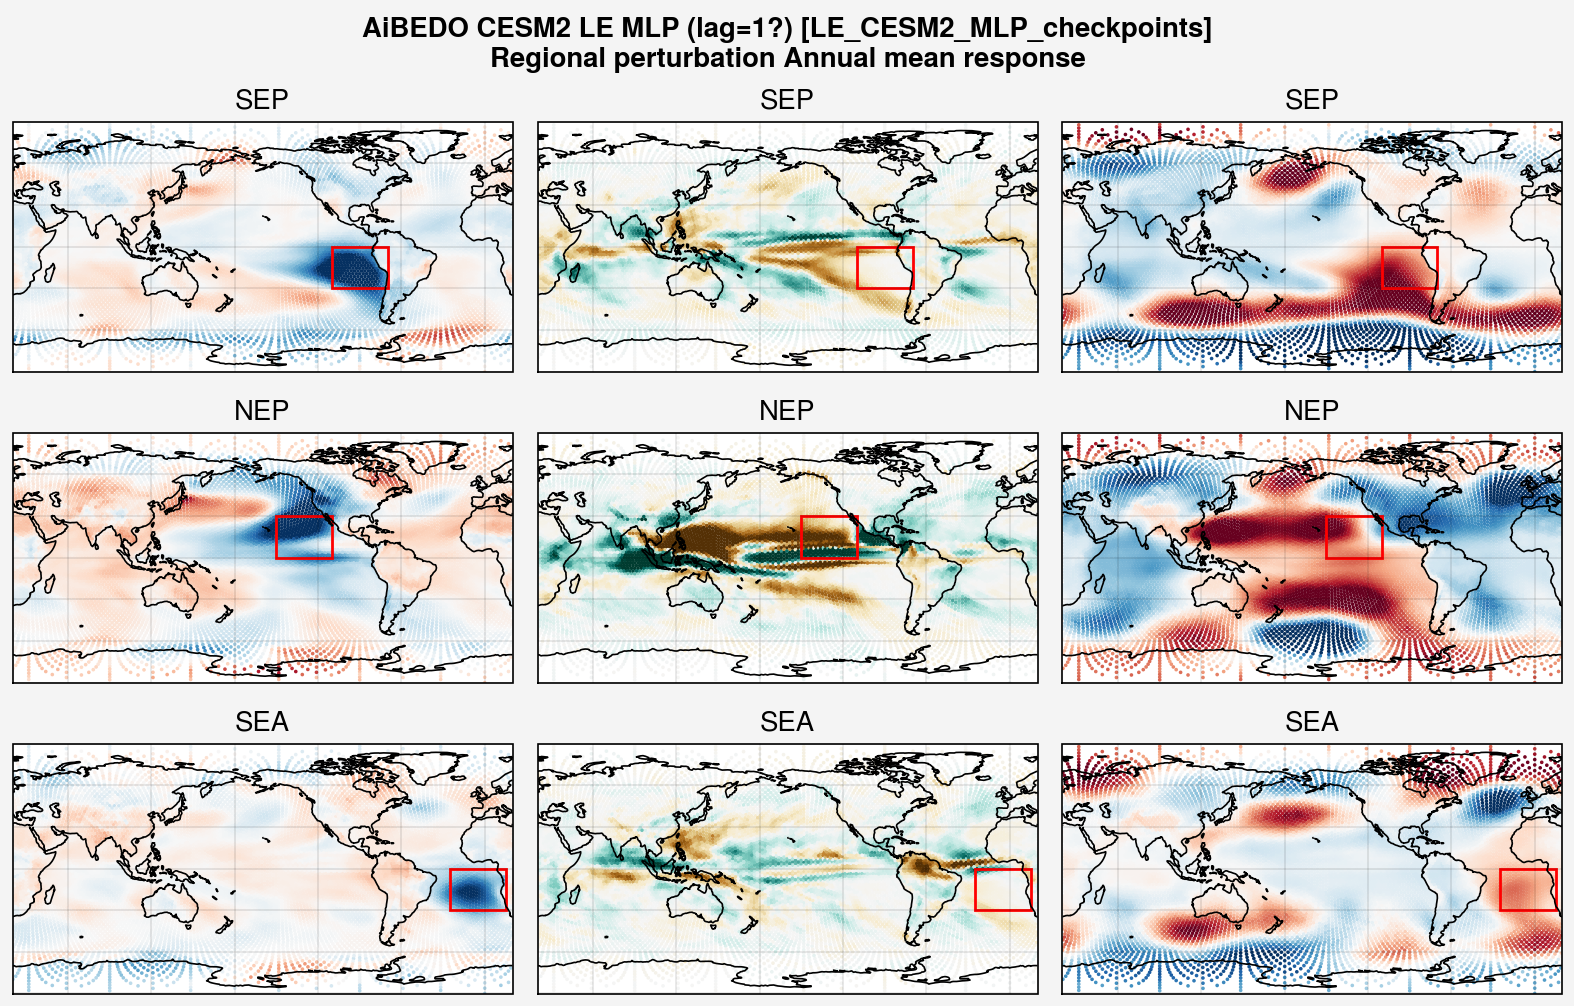

In [27]:
# plot different ens members
lon0 = 200
timesel = slice("1900-01-01","1909-12-31")
fig,axes = pplt.subplots(nrows=3,ncols=3,proj='cyl',proj_kw={'lon_0': lon0})
fig.format(coast=True)
boxcorners = {'NEP':[-150,0],'SEP':[-110, -30], 'SEA':[-25,-30]}

vmax = 0.1
for i,reg in enumerate(['SEP','NEP','SEA']):
    ax = axes[i,0]
    ax.set_title(reg)
    # plot time-mean anomaly relative to the reference baseline
    con = ax.scatter(d_dspert[reg].lon,d_dspert[reg].lat,c = np.mean(d_dspert[reg]['tas_nonorm'],axis=0) - \
                     np.mean(d_dspert_clim['tas_nonorm'],axis=0), s= 0.5,
                     vmax=vmax,vmin=-vmax,extend='both',cmap = 'RdBu_r')
    
    pat2 = patches.Rectangle((360 - lon0 + boxcorners[reg][0],boxcorners[reg][1]), 40, 30,
                            linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(pat2)
    # ax.colorbar(con,label = 'Temperature (K)')

    
    ax = axes[i,1]
    ax.set_title(reg)
    con = ax.scatter(d_dspert[reg].lon,d_dspert[reg].lat,c = np.mean(d_dspert[reg]['pr_nonorm'],axis=0) - \
                     np.mean(d_dspert_clim['pr_nonorm'],axis=0), s= 0.5,
                     vmax=vmax,vmin=-vmax,extend='both',cmap = 'BrBG')
    
    pat2 = patches.Rectangle((360 - lon0 + boxcorners[reg][0],boxcorners[reg][1]), 40, 30,
                            linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(pat2)
    # ax.colorbar(con,label = 'Precipitation (mm/day)')

    ax = axes[i,2]
    ax.set_title(reg)
    con = ax.scatter(d_dspert[reg].lon,d_dspert[reg].lat,c = np.mean(d_dspert[reg]['ps_nonorm'],axis=0) - \
                     np.mean(d_dspert_clim['ps_nonorm'],axis=0), s= 0.5,
                     vmax=vmax,vmin=-vmax,extend='both',cmap = 'RdBu_r')
    
    pat2 = patches.Rectangle((360 - lon0 + boxcorners[reg][0],boxcorners[reg][1]), 40, 30,
                            linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(pat2)
    # ax.colorbar(con,label = 'Surface Pressure (hPa)')

fig.suptitle('AiBEDO CESM2 LE MLP (lag=1?) [LE_CESM2_MLP_checkpoints]\nRegional perturbation Annual mean response')

## Test Dash components with this code and data

In [15]:
from dash import Dash, dcc, html, dash_table, Input, Output, callback
import plotly.express as px
import dash_bootstrap_components as dbc
from dash_bootstrap_templates import ThemeChangerAIO, template_from_url

In [16]:
import xarray as xr
import cartopy.crs as crs
import cartopy.feature as cfeature

In [17]:
lon_list = ds_input.lon.data
lat_list = ds_input.lat.data

In [18]:
len(lon_list)

10242

In [19]:
marker_size_array = np.full((lat_list.shape[0]), 1.)

In [30]:
new_array = np.vstack((lat_list[:2562], lon_list[:2562], marker_size_array[:2562]))

column_name = ['lat', 'lon', 'm_size']
# creating the dataframe
new_df = pd.DataFrame(data = new_array.T, 
                  columns = column_name)

In [31]:
new_df

,lat,lon,m_size
0,58.282526,-90.000000,1.0
1,-58.282526,-90.000000,1.0
2,58.282526,90.000000,1.0
3,-58.282526,90.000000,1.0
4,0.000000,121.717474,1.0
...,...,...,...
2557,2.366942,-27.684972,1.0
2558,9.265316,-23.537323,1.0
2559,2.367103,-19.537602,1.0
2560,6.877991,-27.659910,1.0


In [76]:
## Create a df from a dataset on demain: important for dash application
resolution = 2562
timeslice = slice("1900-01-01","1900-01-01" )
varname = 'netSurfcs_nonorm'

lon_list = ds_input.lon.data[:resolution]
lat_list = ds_input.lat.data[:resolution]
marker_size_array = np.full((lat_list.shape[0]), 1.)
vardata_array = ds_input.sel(time=timeslice)[varname][0][:resolution].data
column_name = ['lat', 'lon', 'm_size', varname]

new_df = pd.DataFrame(data = np.vstack((lat_list, lon_list, marker_size_array, vardata_array)).T, 
                  columns = column_name)





In [78]:
fig = px.scatter_geo(new_df, lat="lat", lon="lon",
                     color=varname, # which column to use to set the color of markers
                     #hover_name="val1", # column added to hover information
                     size="m_size",
                     size_max=3, # size of markers
                     projection="equirectangular",
                     color_continuous_scale='Turbo',
                     basemap_visible=True)
fig.show()